In [1]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-

from fun_ky import *
from fun_map import *
from fun_gui import *
mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 2 
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

########## Input 
dir_path = '/home/etsai/BNL/Research/KY_platelets/saxs/analysis/'
dir_path = '/home/etsai/BNL/Users/SMI/CMurray/2018C3_CMurray_data/saxs/'
feature_args = {
                'source_dir': dir_path,
                'filename'  : 'medium_as-synth_highC_f*10.00s', 
                'filename'  : 'medium_G1_13mgml_m*5.00s', 
                #'filename'  : 'medium_G2-2G1_highC_m*10.00s',  
                #'filename'  : 'medium_G2-2G1_lowC_*10.00s', 
                'filename'  : 'medium_G2-3G1_20mgml_f*5.00s',
                #'filename'  : 'medium_G2-3G1_17mgml_*5.00s', 
                #'filename'  : '14_As-synthesized_DEG_Grid',  #x-0.350_y0.20 #14_As-synthesized_DEG_Grid',
                'exclude': ['072641', '072729', '079729', '081511',  
                            '0698', '06996', '06997',
                            '074831', '074833'], 
                'direct': True, ###
                'feature_id': 1, 
                'map_type': 'xy',
                'log10'  : 0, 
                'verbose': 1,
                'plot_interp':  [None, 0.001], #None, 'linear'(recommended), 'cubic', 'nearest', pixel in mm
                'subplot': False #False when jupyter 
               } 

feature_1_args = {'source_dir' : dir_path+'analysis/qr_image/', 'ext' : '.npz',
             'protocols': [Protocols.qr_image()], 
             'targets' : [],  # [[190, 43], [123, 123]]
             'roi': [1, 'mean'],    # [*] Choose +/- n pixels to include
             }

feature_2_args = {'source_dir' : dir_path+'analysis/circular_average/', 'ext' : '.dat', 'data_col' : [0, 2],
             'protocols': [Protocols.circular_average()], 
             'targets' : [0.075], 
             'roi': [3, 'mean'],    # [*] Choose the half-width (data points) of the peak q
             'N_peaks_find': 5
             }
                   
feature_3_args = {'source_dir' : dir_path+'analysis/linecut_angle092/', 'ext' : '.dat', 'data_col' : [0, 1],
             'protocols': [Protocols.linecut_angle(q0=feature_2_args['targets'], dq=0.002)], 
              'angle_roi': [6, 'mean'], #[-61,  1], # range [0, 60] or N_fold [6, 'mean']
             'targets': [], #['argmax','var'], #[6.6, 9.5, 12.6,32, 35, 49], #, 'var', 10, 26, 36, 42 , 57, 59, 69], #'max', #[21] # 'max', 'var', or specify angle 
             'normalize': True, # normalize by sum(I)
             'N_peaks_find': 15,
             }

feature_4_args = {'source_dir' : dir_path+'analysis/circular_average/', 'ext' : '.dat', 'data_col' : [0, 2],
             'protocols': [Protocols.circular_average()], 
              'fit_range': [0.085, 0.097],  
             'chi2_thr': 0.001, # only consider pixels above this threshold
             'targets': ['b', 'prefactor1', 'x_center1', 'd_spacing_nm', 'grain_size_nm', 'chi2'] #b, prefactor1, x_center1, sigma1, chi2
             }

feature_args.update(feature_1_args=feature_1_args, feature_2_args=feature_2_args, feature_3_args=feature_3_args, feature_4_args=feature_4_args)


# =============================================================================
# The usual: calibration, mask, and process args
# =============================================================================
calibration = Calibration(wavelength_A=0.770088) # 16.1 keV
calibration.set_image_size(981, height=1043) # Pilatus1M
calibration.set_pixel_size(pixel_size_um=172.0)

mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
mask = Mask(mask_dir+'Dectris/Pilatus1M_main_gaps-mask.png')
mask.load(dir_path+'analysis/Pilatus1M_bad_pixel.png') 
filename = feature_args['filename']
if ('medium_G2-2G1' in filename) or ('medium_as-synth' in filename):
    calibration.set_distance(5.300)
    calibration.set_beam_position(452.0, 566.0) # medium_G2; medium_as-synth (round2 samples)
    mask.load(dir_path+'analysis/Pilatus1M_current-mask.png') 
else:
    calibration.set_distance(2.300)
    calibration.set_beam_position(493.0, 560.0) # medium_G1_13mgml_; medium_G2-3G1_
    mask.load(dir_path+'analysis/Pilatus1M_current-mask2.png')
    
load_args = { 'calibration' : calibration,
             'mask' : mask,
             }
run_args = { 'verbosity' : 0,
            'plot_save': False,
            'threshold': 65000
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)
if feature_args['direct']:
    feature_args['process'] = process
    

# =============================================================================
# Find matching files
# =============================================================================
infiles, match_re = get_filematch(feature_args)  


medium_G2-3G1_20mgml_f*5.00s*.tif
Considering 1000 files...
  - Now considering 1000 files...


medium_G2-3G1_20mgml_f*5.00s*.dat
Considering 1000 files...
  - Now considering 1000 files...


<IPython.core.display.Javascript object>


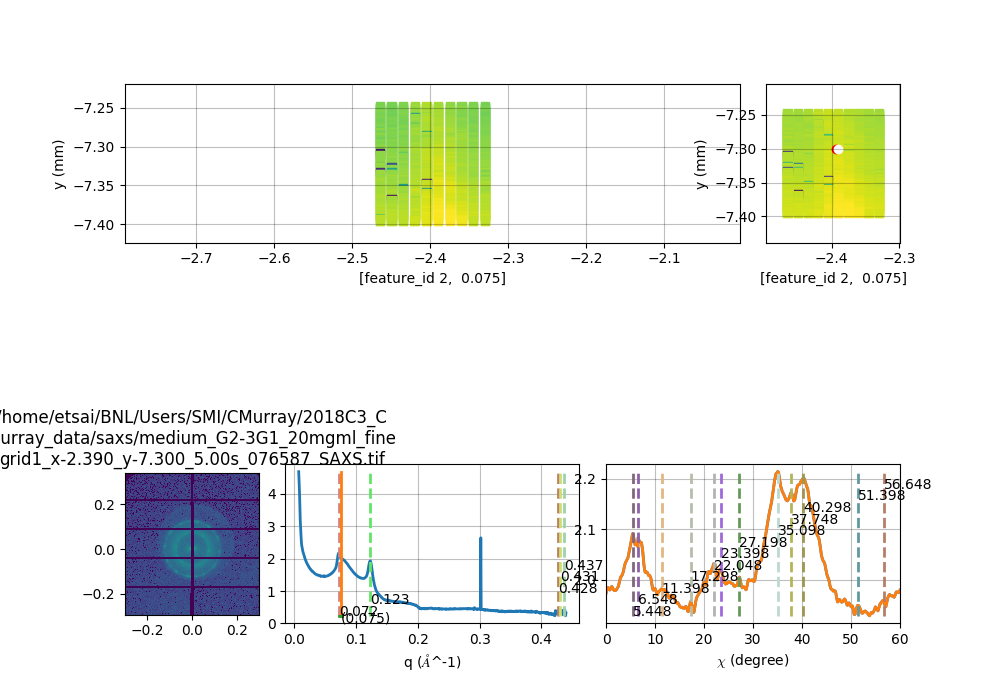

In [2]:
# =============================================================================
# Given x,y and a list of data positions, find the closest point with data
# =============================================================================
def get_closest(pos, post_list):# pos_list is 2 by N
    r_min = 1e10;
    for idx, item in enumerate(post_list[0]):
        x = post_list[0][idx]
        y = post_list[1][idx]
        r = calc_distance(pos, [x, y])
        if r<r_min:
            r_min = r
            xf = x; yf = y
            #idxf = int(idx)
    return xf, yf

def calc_distance(p0, p1):
    r =  math.hypot(p0[0]-p1[0], p0[1]-p1[1])
    return r
# =================


##### Click on map to show data
feature_args.update(feature_id = 2);
feature_args['direct'] = False # temporary off, faster
infiles, match_re = get_filematch(feature_args) 
features_map = get_map(infiles, match_re, feature_args) 
x_pos = features_map['x_pos']
y_pos = features_map['y_pos']

%matplotlib nbagg
fig = plt.figure(20, figsize=[10,7]);  fdim = [3, 5]
axis_font = {'fontname':'Arial', 'size':'8', 'weight':'bold'}
cmap = plt.get_cmap('viridis');  feature_args.update(cmap=cmap)   
ax1 = plt.subplot2grid((fdim[0], fdim[1]), (0, 0), colspan=4); ax1.cla()
feature_args['plot_interp'] = [None, 1]
plot_map(features_map, **feature_args)

pos = []
feature_args['direct'] = True
def onclick(event):   
    
    xc = event.xdata; 
    yc = event.ydata 
    xf, yf = get_closest([xc, yc], [x_pos, y_pos])
    
    ax2 = plt.subplot2grid((fdim[0], fdim[1]), (0, 4), colspan=1); ax2.cla()
    plot_map(features_map, **feature_args)
    plt.scatter(xc,yc,color='r') # clicked    
    plt.scatter(xf,yf,color='w') # position found in the data position list
    
    feature_ids = [1,2,3]
    feature_3_args['protocals'] = [Protocols.linecut_angle(q0=0.123, dq=0.002)]
    
    colidx = 0
    for idx, feature_id in enumerate(feature_ids):
        feature_args.update(feature_id=feature_id); 
        infiles = find_file(xf, yf, feature_args)
        
        colspan = 2 if feature_id>1 else 1
        ax2 = plt.subplot2grid((fdim[0], fdim[1]), (2, colidx), colspan=colspan); ax2.cla()
        colidx = colidx+colspan
        if feature_id==1:
            feature_args.update(verbose=1)
            feature_args.update(log10=[0, 1])
        else:
            feature_args.update(verbose=0)
            feature_args.update(log10=[0, 1])
        if infiles!=[]: 
            plot_data(infiles[0], **feature_args)
    
fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()


<IPython.core.display.Javascript object>


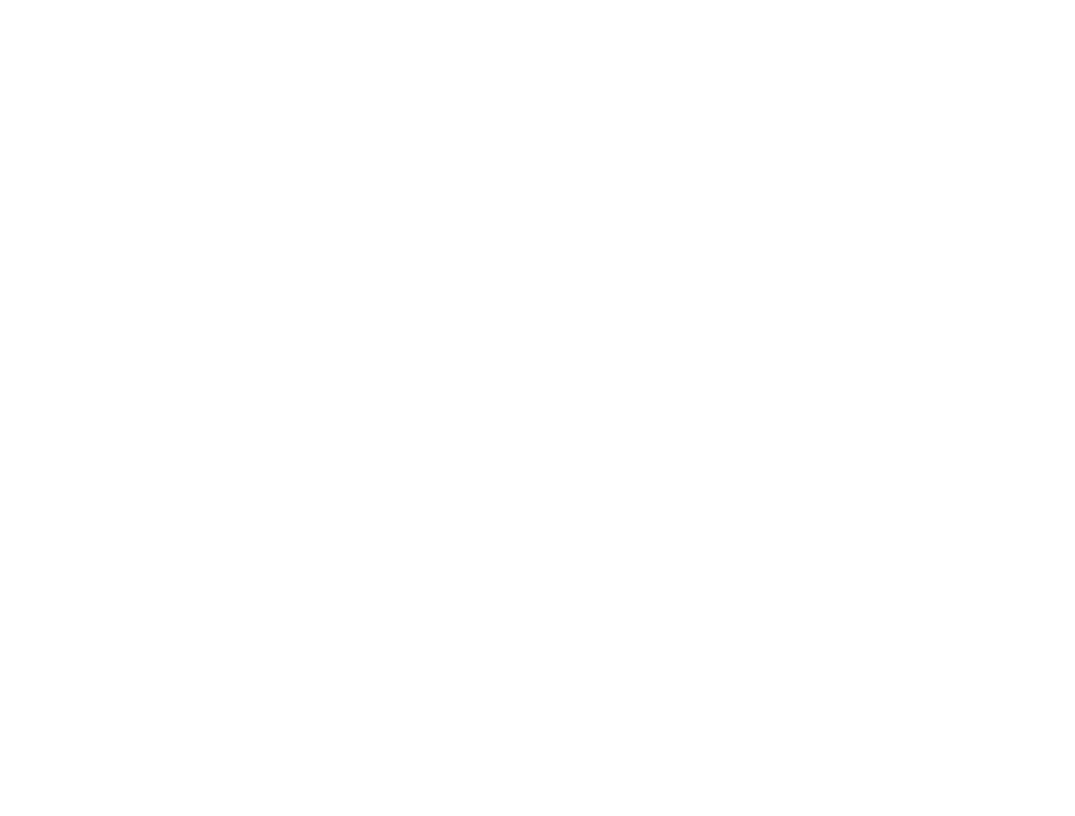

In [23]:
## Plot one data 
if True:
    feature_args.update(feature_id=1); 
    infiles, match_re = get_filematch(feature_args) 
    fig = plt.figure(200+feature_args['feature_id']); plt.clf()
    cmap = plt.get_cmap('jet');  feature_args.update(cmap=cmap)    
    #feature_args.update(filename='*074852');   infiles, match_re = get_filematch(feature_args)
    feature_args.update(log10=1)
    feature_args.update(val_stat = [1, 3])
    if infiles!=[]: 
        plot_data(infiles[0], **feature_args)

In [9]:
########## Plot all feature map
feature_show = [2]
for idx in feature_show:
    feature_args.update(feature_id=idx); 

    ## Find matching files
    infiles, match_re = get_filematch(feature_args)  

    ## Get map
    features_map = get_map(infiles, match_re, feature_args) 
    
    ## Plot map
    fig = plt.figure(10+feature_args['feature_id'], figsize=[9,5]); plt.clf()
    cmap = plt.get_cmap('viridis');    feature_args.update(cmap=cmap)
    #feature_args.update(filename='*072444');   infiles, match_re = get_filematch(feature_args)
    feature_args.update(plot_interp=['linear', 0.001])
    #feature_args.update(val_stat = [0, 20])
    plot_map(features_map, **feature_args)
    
    fig = plt.figure(20+feature_args['feature_id'], figsize=[9,5]); plt.clf()
    feature_args.update(log10=[0, 1])
    plot_data(infiles[0], **feature_args)


KeyboardInterrupt: 

In [3]:
#### bqplot.heatmap
from bqplot import *
import bqplot.pyplot as bplt
from skimage import color
from fun_gui import *

%matplotlib nbagg

def handle_slider_change(change):
    map1.color = color.rgb2gray(io.imread(infiles[change.new]))
    fig.title = infiles[change.new]+' - Scan'+str(change.new)

if feature_args['feature_id']==1:
    value_init = 0;
    img = color.rgb2gray(io.imread(infiles[value_init])); m, n = img.shape              
    x_sc, y_sc, c_sc, ax_x, ax_y, ax_c = bqplot_ax()
    map1 = bplt.heatmap(img, x=np.arange(1,m,1), y=np.arange(1,n,1), scales={'x': x_sc, 'y': y_sc, 'color': c_sc})

    fig = Figure(marks=[map1], animation_duration=100, axes=[ax_x,ax_y,ax_c])
    fig.title = infiles[value_init]
    fig.max_aspect_ratio = 1

    scan_slider = widgets.IntSlider(min=0, max=100, step=1, description='Scan', value=value_init)
    scan_slider.observe(handle_slider_change, 'value')

    play_button = widgets.Play(min=0, max=100, interval=1000)
    widgets.jslink((play_button, 'value'), (scan_slider, 'value'))
    widgets.VBox([widgets.HBox([play_button, scan_slider]), fig])


In [ ]:
##### Slider for viewing all data
def slider_data(scan):      
    ## Plot one data 
    cmap = 'magma';  # 'viridis' 'magma' 'RdYlGn' 'RdYlBu' (https://matplotlib.org/examples/color/colormaps_reference.html)
    feature_args.update(cmap=cmap)

    fdim = [2, 1]
    for idx in [1,2]:
        feature_args.update(feature_id=idx); 
        infiles, match_re = get_filematch(feature_args) 
        ax = plt.subplot2grid((fdim[0], fdim[1]), (idx-1, 0), colspan=1); ax.cla() 
        if infiles!=[]:
            plot_data(infiles[scan], feature_args)  
    plt.show() 

%matplotlib nbagg
fig = plt.figure(10, figsize=[8,8]); plt.clf()
w = widgets.interactive(slider_data, scan=(0,len(infiles)-1))
w